creating libraries

In [4]:
#Importing essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize


getting experimental values

In [5]:
#importing from experimental file
# Num Nuc  A   N   Z        E        E/A     dE     Eval    S1n     dS1n  Eval    
# 0   1    2   3   4        5        6       7      8       9       10    11

#S1p     dS1p  Eval    S2n     dS2n  Eval    S2p     dS2p  Eval
#12      13    14      15      16    17      18      19    20

N_exp  = np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=3) #Number of neutrons
Z_exp  = np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=4) #Number of protons
X_exp  = np.transpose(np.stack((Z_exp,N_exp)))
A_exp  = N_exp+Z_exp # Total number of Nucleons

# Difference between the experimental binding energy and the Liquid drop model
y_exp  = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=5)
dy_exp = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=7)

S_p_exp  = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=12)
S_2p_exp = -np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=18)

S_n_exp =-np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=9)
S_2n_exp=-np.genfromtxt('EXPERIMENT_AME2016.dat',usecols=15)

X_exp     = np.transpose(np.stack((Z_exp,   N_exp,  A_exp,  y_exp)))

y_exp_d={}
S_n_exp_d={}
S_2n_exp_d={}

for i in range(0,len(N_exp)):
    y_exp_d[Z_exp[i], N_exp[i]]=y_exp[i]
    S_n_exp_d[Z_exp[i], N_exp[i]]=S_n_exp[i]
    S_2n_exp_d[Z_exp[i], N_exp[i]]=S_2n_exp[i]

getting SKMS values

In [6]:
#SKMS importing relevent data
#Symbol Z  N A Binding_Energy_(MeV)  S_p_(MeV)  S_{2p}_(MeV) S_n_(MeV)  S_{2n}_(MeV) Q_{alpha}_(MeV)       
#0      1  2 3 4                     5          6            7          8            9

Z_SKMS    = np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=1) #Number of protons
N_SKMS    = np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=2) #Number of neutrons
A_SKMS    = N_SKMS+Z_SKMS                                      #Total number of Nucleons
y_SKMS    = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=4)

S_p_SKMS  = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=5)
S_2p_SKMS = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=6)

S_n_SKMS  = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=7)
S_2n_SKMS = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=8)

Q_SKMS    = -np.genfromtxt('SKMS_all_nuclei-new.dat',usecols=9)

S_p_SKMS  = np.where(np.isnan(S_p_SKMS), 0, S_p_SKMS)
S_2p_SKMS = np.where(np.isnan(S_2p_SKMS), 0, S_2p_SKMS)

S_n_SKMS  = np.where(np.isnan(S_n_SKMS), 0, S_n_SKMS)
S_2n_SKMS = np.where(np.isnan(S_2n_SKMS), 0, S_2n_SKMS)

Q_SKMS=np.where(np.isnan(Q_SKMS), 0, Q_SKMS)

X_SKMS    = np.transpose(np.stack((Z_SKMS, N_SKMS, A_SKMS, y_SKMS, S_p_SKMS, S_2p_SKMS, S_n_SKMS, S_2n_SKMS, Q_SKMS)))
NZ_SKMS   = np.transpose(np.stack((Z_SKMS, N_SKMS)))

y_SKMS_d    ={}
S_p_SKMS_d  ={}
S_2p_SKMS_d ={}

S_n_SKMS_d  ={}
S_2n_SKMS_d ={}

Q_SKMS_d    ={}

for i in range(0,len(X_SKMS)):
    y_SKMS_d[Z_SKMS[i], N_SKMS[i]]=y_SKMS[i]
    S_p_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_p_SKMS[i]
    S_2p_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_2p_SKMS[i]
    S_n_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_n_SKMS[i]
    S_2n_SKMS_d[Z_SKMS[i], N_SKMS[i]]=S_2n_SKMS[i]
    Q_SKMS_d[Z_SKMS[i], N_SKMS[i]]=Q_SKMS[i]


# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size




Finding where experimental and theoretical values match

In [7]:
y_matSKMS_d  ={}

Q_matSKMS_d  ={}
y_matexp_d   ={}
Q_matexp_d   ={}

N_mat        =[]
Z_mat        =[]

y_matexp     =[]
y_matSKMS    =[]

diff_mat     =[]
Q_matSKMS    =[]
Q_matexp     =[]

for n in range(0, 177+1):
    for z in range(0, 118+1):
        try:
            if y_exp_d[z,n]!=0 and y_SKMS_d[z,n]!=0:
                y_matSKMS_d[z,n]=y_SKMS_d[z,n]
                Q_matSKMS_d[z,n]=Q_SKMS_d[z,n]
                
                y_matexp_d[z,n] =y_exp_d[z,n]
                #Q_matexp_d[z,n]=Q_exp_d[z,n]
            
                N_mat.append(n)
                Z_mat.append(z)
                y_matexp.append(y_exp_d[z,n])
                y_matSKMS.append(y_SKMS_d[z,n])
                diff_mat.append(y_exp_d[z,n]-y_SKMS_d[z,n])
                Q_matSKMS.append(Q_SKMS_d[z,n])
                #Q_matexp.append(Q_exp_d[z,n])
                
                
        except KeyError:
            continue


                
                
S_n_matexp_d={} 
S_n_matSKMS_d={}
S_n_matexp=[] 
S_n_matSKMS=[]

S_p_matSKMS=[]

N_S_n_mat=[]
Z_S_n_mat=[]

Q_S_n_matSKMS_d={}
diff_S_n_mat=[]
Q_S_n_matSKMS=[]


for n in range(0, 177+1):
    for z in range(0, 118+1):
        try:
            if S_n_exp_d[z,n]!=0 and S_n_SKMS_d[z,n]!=0:
                S_n_matexp_d[z,n] =S_n_exp_d[z,n]
                S_n_matSKMS_d[z,n]=S_n_SKMS_d[z,n]
                S_n_matexp.append(S_n_exp_d[z,n]) 
                S_n_matSKMS.append(S_n_SKMS_d[z,n])
                
                S_p_matSKMS.append(S_p_SKMS_d[z,n])
                
                N_S_n_mat.append(n)
                Z_S_n_mat.append(z)
                
                Q_S_n_matSKMS_d[z,n]=Q_SKMS_d[z,n]
                
                diff_S_n_mat.append(y_exp_d[z,n]-y_SKMS_d[z,n])
                Q_S_n_matSKMS.append(Q_SKMS_d[z,n])
                
        except KeyError:
            continue
            

N_nomatSKMS=[]
Z_nomatSKMS=[]
y_nomatSKMS=[]
Q_nomatSKMS=[]
S_n_nomatSKMS=[]
S_p_nomatSKMS=[]


for n in range(0, 301):
    for z in range(0, 121):
        try:
            #print('y_exp_d[n, z]')
            y_exp_d[z,n]
            
        except KeyError:
            try:
                #print('if y_SKMS_d[n,z]!=0:')
                if y_SKMS_d[z,n]!=0:
                    #print('N_nomatSKMS=n')
                    N_nomatSKMS.append(n)
                    Z_nomatSKMS.append(z)
                    y_nomatSKMS.append(y_SKMS_d[z,n])
                    Q_nomatSKMS.append(Q_SKMS_d[z,n])
                    S_n_nomatSKMS.append(S_n_SKMS_d[z,n])
                    S_p_nomatSKMS.append(S_p_SKMS_d[z,n])
                    
            except KeyError:
                #print('continue')
                continue
                
        continue
                
    
            
            
  
          

Finding the drip line for the SKMS values

In [8]:
#X_SKMS    = np.transpose(np.stack((Z_SKMS, N_SKMS, A_SKMS, y_SKMS, S_p_SKMS, S_2p_SKMS, S_n_SKMS, S_2n_SKMS, Q_SKMS)))
ndrip_SKMS=[]
zdep_SKMS =[]

zdrip_SKMS=[]
ndep_SKMS =[]


for i in range(0,len(X_SKMS)):
    try:
        if X_SKMS[i-1][0] != X_SKMS[i][0]:
            #print(X_SKMS[i][0]) 
            zdrip_SKMS.append(X_SKMS[i][0])
            ndep_SKMS.append(X_SKMS[i][1])
    
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        zdrip_SKMS.append(X_SKMS[i-1][0])
        ndep_SKMS.append(X_SKMS[i-1][1])
             
for i in range(2,len(X_SKMS)):
    try:
        if X_SKMS[i+1][0] != X_SKMS[i][0]:
            #print(X_SKMS[i][0]) 
            ndrip_SKMS.append(X_SKMS[i][1])
            zdep_SKMS.append(X_SKMS[i][0])
        
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        ndrip_SKMS.append(X_SKMS[i][1])
        zdep_SKMS.append(X_SKMS[i][0])
    
zdripndep_SKMS = np.transpose(np.stack((zdrip_SKMS,ndep_SKMS )))
ndripzdep_SKMS = np.transpose(np.stack((ndrip_SKMS,zdep_SKMS )))




allvals=[]
for i in range(0,118):
    for n in range(int(ndep_SKMS[i])-30, int(ndrip_SKMS[i])+30):
        allvals.append([zdep_SKMS[i], n])

allvals=np.array(allvals) 
allvals=np.transpose(allvals)


Creating experimental N and Z drip lines

In [9]:
ndrip_exp=[]
zdep_exp=[]

zdrip_exp=[]
ndep_exp=[]


for i in range(0,len(X_exp)):
    try:
        if X_exp[i-1][0] != X_exp[i][0]:
            #print(X_SKMS[i][0]) 
            zdrip_exp.append(X_exp[i][0])
            ndep_exp.append(X_exp[i][1])
    
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        zdrip_exp.append(X_exp[i-1][0])
        ndep_exp.append(X_exp[i-1][1])
             
for i in range(2,len(X_exp)):
    try:
        if X_exp[i+1][0] != X_exp[i][0]:
            #print(X_SKMS[i][0]) 
            ndrip_exp.append(X_exp[i][1])
            zdep_exp.append(X_exp[i][0])
        
    except IndexError:
        #print('except', i,  X_SKMS[i][0])
        ndrip_exp.append(X_exp[i][1])
        zdep_exp.append(X_exp[i][0])
    
    
    
zdripndep_exp = np.transpose(np.stack((zdrip_exp,ndep_exp )))
ndripzdep_exp = np.transpose(np.stack((ndrip_exp,zdep_exp )))


#plt.plot(np.transpose(ndripzdep_exp)[0], np.transpose(ndripzdep_exp)[1],label='python neutron drip line')
#plt.plot(np.transpose(zdripndep_exp)[1], np.transpose(zdripndep_exp)[0],label='python proton drip line')
#plt.plot(np.transpose(ndripzdep_SKMS)[0][0:-1], np.transpose(ndripzdep_SKMS)[1][0:-1],label='python neutron drip line')
#plt.plot(np.transpose(zdripndep_SKMS)[1][0:-1], np.transpose(zdripndep_SKMS)[0][0:-1],label='python proton drip line')
#plt.plot(allvals[1], allvals[0], 'o', markersize=1)
#plt.plot(N_exp,  Z_exp, 'o', markersize=2, label='experimental')
#plt.ylabel('Proton  #')
#plt.xlabel('Neutron #')
#plt.legend()
#plt.show()

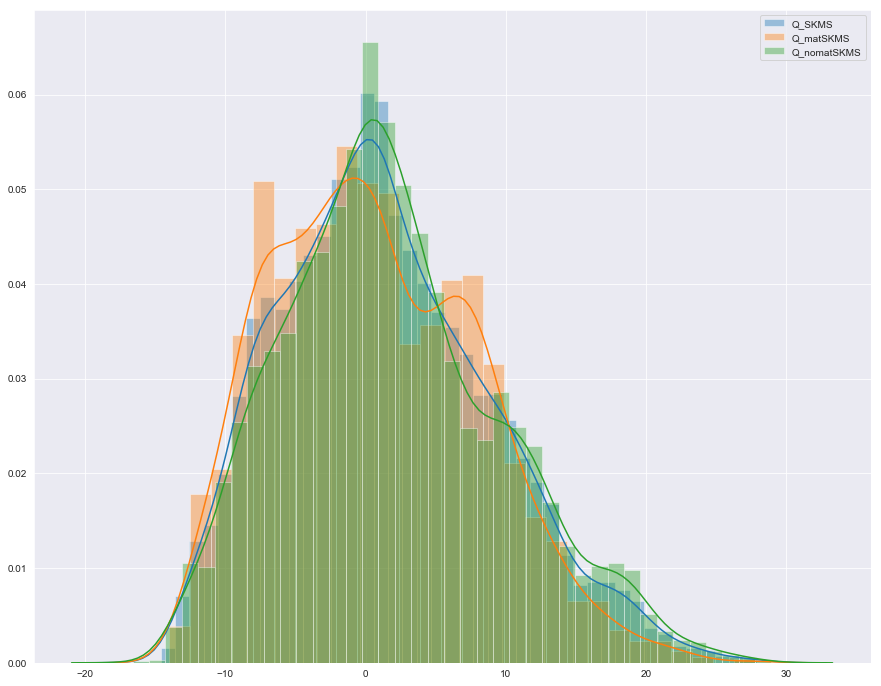

In [10]:
sns.set_style('darkgrid')
sns.distplot(Q_SKMS, label='Q_SKMS')
sns.distplot(Q_matSKMS, label='Q_matSKMS')
sns.distplot(Q_nomatSKMS, label='Q_nomatSKMS')
plt.legend()
#make a histogram of q valies of that matching nz values and the skms q values
#hist

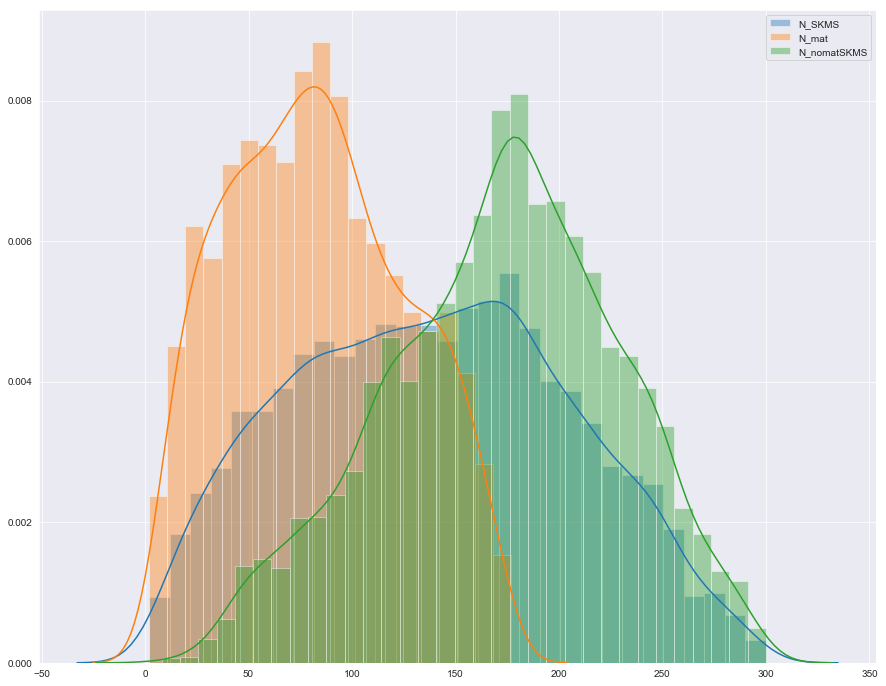

In [11]:
#sns.set_style('darkgrid')
sns
sns.distplot(N_SKMS, label='N_SKMS')
sns.distplot(N_mat, label='N_mat')
sns.distplot(N_nomatSKMS, label='N_nomatSKMS')
plt.legend()

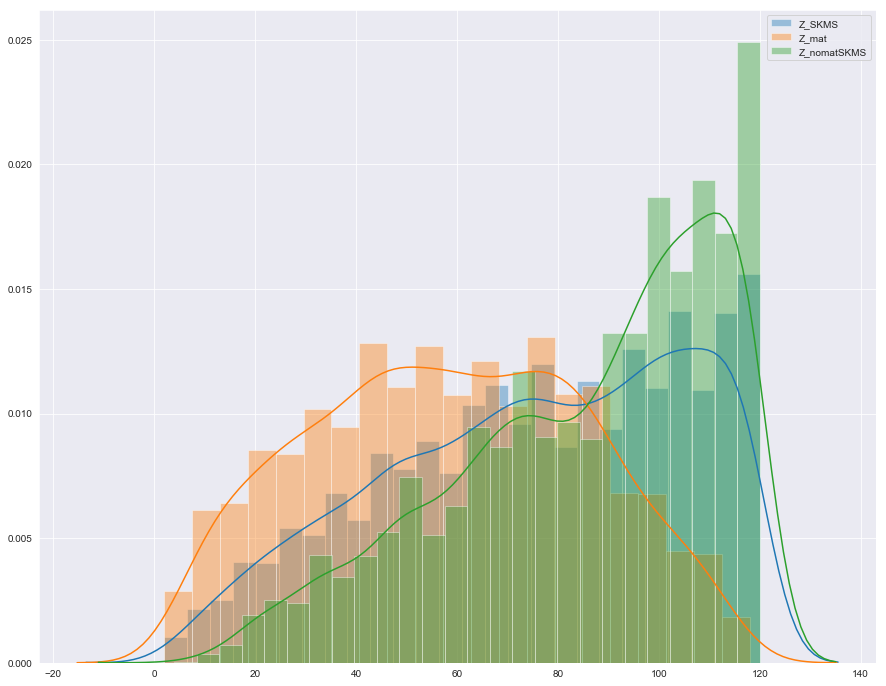

In [12]:
sns.set_style('darkgrid')
sns.distplot(Z_SKMS, label='Z_SKMS')
sns.distplot(Z_mat, label='Z_mat')
sns.distplot(Z_nomatSKMS, label='Z_nomatSKMS')
plt.legend()

In [13]:
def ki(exp, theo):
    ki_2=0
    
    for i in range(0, len(exp)):
        ki_2=ki_2+(exp[i]-theo[i])**2

    return ki_2/len(exp)
    

In [14]:
NZ_mat=np.transpose(np.stack((Z_mat,N_mat)))
NZ_mat=np.array(NZ_mat)

rf_NZ=RandomForestRegressor(n_estimators=1000)

X_train, X_test, y_train, y_test = train_test_split(NZ_mat, diff_mat, test_size =0.25, random_state=42 )
rf_NZ.fit(X_train,y_train)
print(rf_NZ.score(X_train,y_train))
print(rf_NZ.score(X_test,y_test))


ZN_train=X_train
ZN_test =X_test
diff_NZ=rf_NZ.predict(NZ_mat)
diff_NZ=rf_NZ.predict(NZ_SKMS)


y_train_SKMS  =[]
y_test_SKMS   =[]
y_train_exp   =[]
y_test_exp    =[]




for i in range(0, len(X_train)):
    y_train_SKMS.append(y_matSKMS_d[  ZN_train[i][0],  ZN_train[i][1]  ])
    y_train_exp.append( y_matexp_d[   ZN_train[i][0],  ZN_train[i][1]  ])
    #print(y_SKMS_d[  X_train[i][0],  X_train[i][1]  ])
    #print(y_exp_d[  X_train[i][0],  X_train[i][1]  ])
    
    
for i in range(0, len(X_test)):
    y_test_SKMS.append(y_matSKMS_d[  ZN_test[i][0],  ZN_test[i][1]  ])
    y_test_exp.append( y_matexp_d[   ZN_test[i][0],  ZN_test[i][1]  ])
    #print(y_SKMS_d[  X_train[i][0],  X_train[i][1]  ])
    #print(y_exp_d[  X_train[i][0],  X_train[i][1]  ])

    
#ki_2 for train and test WITHOUT ML
print("NZ rf")
print("ki_2 train set", ki(y_train_exp, y_train_SKMS ))
print("ki_2 test  set", ki(y_test_exp, y_test_SKMS ))
print("ki_2 all   set", ki(y_matexp, y_matSKMS ), "\n")

ki_2_train=ki(y_train_exp, y_train_SKMS)
ki_2_test =ki(y_test_exp, y_test_SKMS )
ki_2_all  =ki(y_matexp, y_matSKMS)



#ki_2 for train and test WITH ML
y_train_SKMS_ml  =y_train_SKMS+rf_NZ.predict(ZN_train)
y_test_SKMS_ml   =y_test_SKMS+ rf_NZ.predict(ZN_test)

print("ki_2 train set with ml", ki(y_train_exp, y_train_SKMS_ml ))
print("ki_2 test  set with ml", ki(y_test_exp,   y_test_SKMS_ml ))


y_all_SKMS_ml=y_matSKMS+rf_NZ.predict(NZ_mat)
print("ki_2 all       with ml", ki(y_matexp, y_all_SKMS_ml), "\n\n")   

NZ_ki_2_train_ml=ki(y_train_exp, y_train_SKMS_ml )
NZ_ki_2_test_ml =ki(y_test_exp,   y_test_SKMS_ml )
NZ_ki_2_all_ml  =ki(y_matexp, y_all_SKMS_ml)




0.9991935210300933
0.9928049869788858
NZ rf
ki_2 train set 53.291500414636374
ki_2 test  set 49.8879751233542
ki_2 all   set 52.44009867510445 

ki_2 train set with ml 0.03519724775802059
ki_2 test  set with ml 0.3226006631198781
ki_2 all       with ml 0.10709204707484064 




In [15]:
ZQ_mat=np.transpose(np.stack((Z_mat, Q_matSKMS)))
ZQ_mat=np.array(ZQ_mat)

ZQ_SKMS=np.transpose(np.stack((Z_SKMS, Q_SKMS)))
ZQ_SKMS=np.array(ZQ_SKMS)

                    
rf_ZQ=RandomForestRegressor(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(ZQ_mat, diff_mat, test_size =0.25, random_state=42 )
rf_ZQ.fit(X_train,y_train)
print(rf_ZQ.score(X_train,y_train))
print(rf_ZQ.score(X_test,y_test))





ml_ZQ=rf_ZQ.predict(ZQ_SKMS)
ml_ZQ_mat=rf_ZQ.predict(ZQ_mat)

#ki_2 for train and test WITHOUT ML
print("ZQ rf")
print("ki_2 train set", ki(y_train_exp, y_train_SKMS ))
print("ki_2 test  set", ki(y_test_exp, y_test_SKMS ))
print("ki_2 all   set", ki(y_matexp, y_matSKMS ), "\n")



#ki_2 for train and test WITH ML
y_train_SKMS_ml  =y_train_SKMS+rf_ZQ.predict(X_train)
y_test_SKMS_ml   =y_test_SKMS+ rf_ZQ.predict(X_test)

print("ki_2 train set with ml", ki(y_train_exp, y_train_SKMS_ml ))
print("ki_2 test  set with ml", ki(y_test_exp,   y_test_SKMS_ml ))


y_all_SKMS_ml=y_matSKMS+rf_ZQ.predict(ZQ_mat)
print("ki_2 all       with ml", ki(y_matexp, y_all_SKMS_ml), "\n\n")   


ZQ_ki_2_train_ml=ki(y_train_exp, y_train_SKMS_ml )
ZQ_ki_2_test_ml =ki(y_test_exp,   y_test_SKMS_ml )
ZQ_ki_2_all_ml  =ki(y_matexp, y_all_SKMS_ml)




0.9859632349394498
0.8702399382984255
ZQ rf
ki_2 train set 53.291500414636374
ki_2 test  set 49.8879751233542
ki_2 all   set 52.44009867510445 

ki_2 train set with ml 0.6126080356620395
ki_2 test  set with ml 5.818013369616058
ki_2 all       with ml 1.914755302687843 




In [16]:
NQ_mat=np.transpose(np.stack((N_mat, Q_matSKMS)))
NQ_mat=np.array(NQ_mat)


NQ_SKMS=np.transpose(np.stack((N_SKMS, Q_SKMS)))
NQ_SKMS=np.array(NQ_SKMS)

                    
rf_NQ=RandomForestRegressor(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(NQ_mat, diff_mat, test_size =0.25, random_state=42 )
rf_NQ.fit(X_train,y_train)
print(rf_NQ.score(X_train,y_train))
print(rf_NQ.score(X_test,y_test))

diff_NQ=rf_NQ.predict(NQ_SKMS)
    

#ki_2 for train and test WITHOUT ML
print("NQ rf")
print("ki_2 train set", ki(y_train_exp, y_train_SKMS ))
print("ki_2 test  set", ki(y_test_exp, y_test_SKMS ))
print("ki_2 all   set", ki(y_matexp, y_matSKMS ), "\n")



#ki_2 for train and test WITH ML
y_train_SKMS_ml  =y_train_SKMS+rf_NQ.predict(X_train)
y_test_SKMS_ml   =y_test_SKMS+ rf_NQ.predict(X_test)

print("ki_2 train set with ml", ki(y_train_exp, y_train_SKMS_ml ))
print("ki_2 test  set with ml", ki(y_test_exp,   y_test_SKMS_ml ))


y_all_SKMS_ml=y_matSKMS+rf_NQ.predict(NQ_mat)
print("ki_2 all       with ml", ki(y_matexp, y_all_SKMS_ml), "\n\n")   


NQ_ki_2_train_ml=ki(y_train_exp, y_train_SKMS_ml )
NQ_ki_2_test_ml =ki(y_test_exp,   y_test_SKMS_ml )
NQ_ki_2_all_ml  =ki(y_matexp, y_all_SKMS_ml)




0.993789516987249
0.9470058026863586
NQ rf
ki_2 train set 53.291500414636374
ki_2 test  set 49.8879751233542
ki_2 all   set 52.44009867510445 

ki_2 train set with ml 0.27104477296172436
ki_2 test  set with ml 2.3760850945949854
ki_2 all       with ml 0.7976267249788508 




In [17]:
print("                 theory                  with rf_NZ,            with rf_ZQ,           with rf_NQ")
print("training Ki_2:  ", ki_2_train, ",    ",  NZ_ki_2_train_ml,",  ", ZQ_ki_2_train_ml,",  ", NQ_ki_2_train_ml  )
print("testing  Ki_2:   ", ki_2_test , ",   ",  NZ_ki_2_test_ml,",  ",  ZQ_ki_2_test_ml,",  ",  NQ_ki_2_test_ml  )
print("all      Ki_2:  ", ki_2_all  , ",   ",  NZ_ki_2_all_ml,",  ",   ZQ_ki_2_all_ml,",  ",   NQ_ki_2_all_ml  )


                 theory                  with rf_NZ,            with rf_ZQ,           with rf_NQ
training Ki_2:   53.291500414636374 ,     0.03519724775802059 ,   0.6126080356620395 ,   0.27104477296172436
testing  Ki_2:    49.8879751233542 ,    0.3226006631198781 ,   5.818013369616058 ,   2.3760850945949854
all      Ki_2:   52.44009867510445 ,    0.10709204707484064 ,   1.914755302687843 ,   0.7976267249788508
